In [1]:
import galarp as grp
grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from matplotlib import pyplot as plt

## Goal: Generate the following figures:

1. $M_{\text{gas}}$ vs $t$
2. $R_{\text{strip}}$ vs $t$
3. $v_z$ vs $z$ as a matrix plot

In [2]:
jz2023_satellite = grp.builtins.JZ2023_Satellite()          # Satellite grav potential
jz2023_cluster_potential = grp.builtins.JZ2023_1e14()       # Host cluster potential
jz2023_cluster_ic = grp.builtins.JZ2023_1e14_IC()           # Satellite galaxy initial conditions

mass_profile = grp.gen_mass_profile(jz2023_satellite)



In [4]:
# Setup initial particle grid

particles = grp.ExponentialGrid(h_R=jz2023_satellite["gas"].parameters["a"],
                           h_z=jz2023_satellite["gas"].parameters["b"],
                           n_particles=10000)

# Only run generate_exponential_positions if temp/positions.npy does not exist

# positions = grp.generate_exponential_positions(h_R=particles.h_R, h_z=particles.h_z,
#                                                n_particles=particles.n_particles,
#                                                Rmax=particles.Rmax, zmax=particles.zmax,
#                                                outname="temp/positions.npy")

particles.generate(mass_profile=mass_profile, positions="temp/positions.npy")


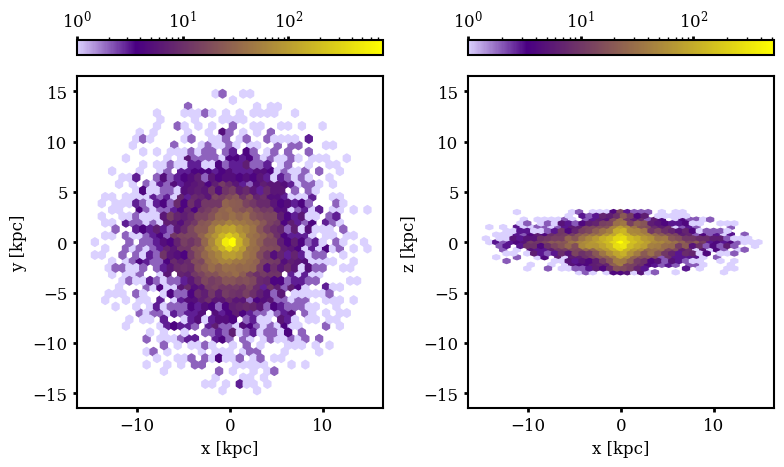

In [5]:

particles.plot_density(cmap=cmap)

In [6]:
inc = 45

wind = grp.InterpolatedWind().from_table("../notebooks/ICMinflow_1e14_group_profile_45degree_wind_stacked_pericenter_data.in",
                                         time_key="col1", vel_keys=["col4", "col5", "col6"],
                                         inc=np.deg2rad(inc))

shadow = grp.UniformShadow(damping=0.4, R_disk = 8 * u.kpc, zmin=0.5 * u.kpc, phi=np.deg2rad(inc))


[6.123234e-17 0.000000e+00 1.000000e+00]
[0.70710678 0.         0.70710678]


## Integrate the RP event with GalaRP

In [10]:
sim = grp.RPSim(potential=jz2023_satellite, wind=wind, shadow=shadow)
print(sim)

orbits = sim.run(particles, )


Ram Pressure Sim 
 Wind: 		<RP Wind Vector=[0.70710678 0.         0.70710678] km / s  Inclination=45.00  >
 Shadow: 	<Uniform RP Shadow:  Phi=45.00  Damping=0.4  R_Disk=8.0 kpc  zmin=0.5 kpc >
 Potential: 	CompositePotential
--------------------------------------------------------------------------------
-------- Running GALA sim with  1.00e+00 km / s  wind at  0.79  degrees --------
------- Running for 500.0 Myr  at a timestep of  5.0 Myr  (100.0 steps) --------
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------


100%|██████████| 99/99 [00:01<00:00, 90.40it/s]
